In [30]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np


In [31]:
# from google.colab import drive
# drive.mount('/content/drive')

In [32]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
EPOCHS = 50

In [33]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle=True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [34]:
class_names =  dataset.class_names
class_names


['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [35]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[0 1 1 0 1 1 0 1 2 1 1 1 1 2 1 1 1 1 0 1 1 1 0 0 1 1 1 0 1 1 0 0]


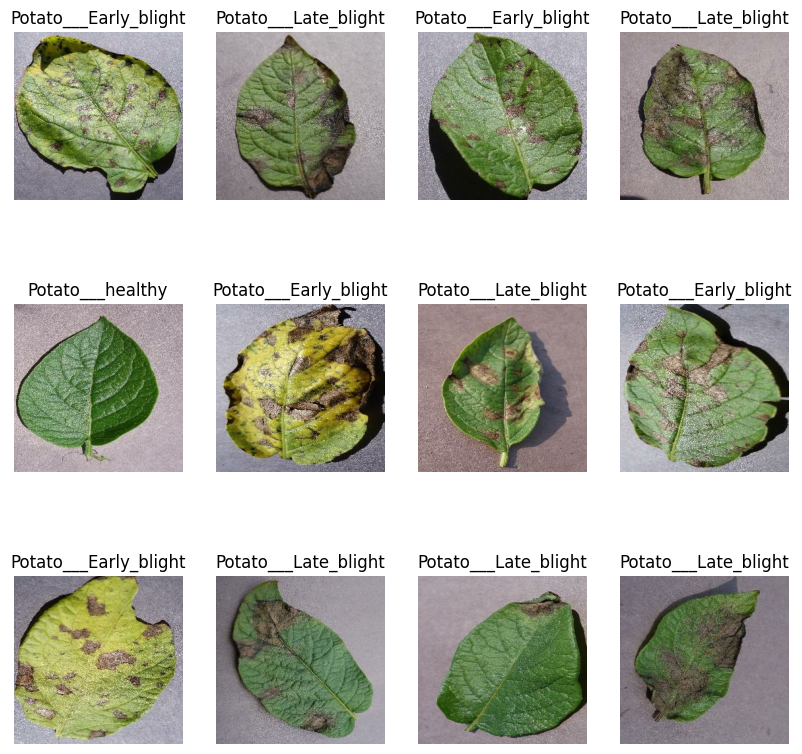

In [36]:
plt.figure(figsize = (10,10))

for image_batch, label_batch in dataset.take(1):
    for i in range(12):

        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")



In [37]:
# 80% ==> training
# 20%==> 10% validation  10% test


In [38]:
len(dataset)

68

In [39]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [40]:
train_ds = dataset.take(54)
len(train_ds)

54

In [41]:
test = dataset.skip(54)
len(test)

14

In [42]:
val_size = .1
len(dataset)*val_size

6.800000000000001

In [43]:
val_ds = test.take(6)
len(val_ds)

6

In [44]:
test_ds = test.skip(6)
len(test_ds)

8

In [45]:
def get_datast_partitions_tf( ds, train_split = .7, val_split = 0.15, test_split=0.15, shuffle = True, shuffle_size = 1000):

    ds_size = len(ds)

    # if shuffle:
    #     ds = ds.shuffle(shuffle_size, seed = 12)

    # train_size = int(train_split*ds_size)
    # val_size = int(val_split * ds_size)

    # train_ds = ds.take(train_size)
    # val_ds = ds.skip(train_size).take(val_size)
    # test_ds = ds.skip(train_size).skip(val_size)
    if shuffle:
      train_size = int(0.8 * len(ds))
      val_size = int(0.1 * len(ds))
      test_size = len(dataset) - train_size - val_size

      # Split the dataset into train, validation, and test sets
      train_ds = ds.take(train_size)
      remaining_ds = ds.skip(train_size)
      val_ds = remaining_ds.take(val_size)
      test_ds = remaining_ds.skip(val_size)

    return train_ds, val_ds, test_ds

In [46]:
train_ds, val_ds, test_ds = get_datast_partitions_tf(dataset)

In [47]:
len(val_ds)

6

In [48]:
 #dataset is optimized for training performance with prefetch and cache

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)


test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)



In [49]:
#scaling rgb from 0-255 to 0-1
 # this Resizing layer will eventualy go to our model and while
    # predicting if it encounter any image that is not IMAGE_SIZE X IMAGE_SIZE
    # then it will take care of that by resizing the image before feeding it to the model.

resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [50]:
#now we are going to use

In [51]:
#data augmentation

data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [52]:
#softmax activation function normalize the probability of the classes
input_shape = (BATCH_SIZE, IMAGE_SIZE,IMAGE_SIZE,3)
n_classes = 3
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),

    layers.Dense(32, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])

model.build(input_shape = input_shape)

In [53]:
tf.keras.applications.densenet.DenseNet201(
    include_top=True,
    weights='imagenet',
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation='softmax'
)

In [54]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 sequential_4 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d_5 (Conv2D)           (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_5 (MaxPoolin  (32, 127, 127, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (32, 125, 125, 32)        9248      
                                                                 
 max_pooling2d_6 (MaxPoolin  (32, 62, 62, 32)          0         
 g2D)                                                 

In [55]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
    metrics=['accuracy']
)

In [56]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 5s 271ms/step - loss: 1.0817 - accuracy: 0.4741


In [57]:
history = model.fit(
    train_ds,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    verbose = 1,
    validation_data = val_ds
)

Epoch 1/50


54/54 [==============================] - 101s 2s/step - loss: 0.9143 - accuracy: 0.4780 - val_loss: 0.9086 - val_accuracy: 0.4531
Epoch 2/50
54/54 [==============================] - 92s 2s/step - loss: 0.7384 - accuracy: 0.6244 - val_loss: 0.7570 - val_accuracy: 0.6302
Epoch 3/50
54/54 [==============================] - 95s 2s/step - loss: 0.4501 - accuracy: 0.8113 - val_loss: 0.3493 - val_accuracy: 0.8802
Epoch 4/50
54/54 [==============================] - 89s 2s/step - loss: 0.3155 - accuracy: 0.8692 - val_loss: 0.3085 - val_accuracy: 0.8906
Epoch 5/50
54/54 [==============================] - 88s 2s/step - loss: 0.2085 - accuracy: 0.9190 - val_loss: 0.2427 - val_accuracy: 0.9062
Epoch 6/50
54/54 [==============================] - 87s 2s/step - loss: 0.2499 - accuracy: 0.8958 - val_loss: 0.2134 - val_accuracy: 0.9271
Epoch 7/50
54/54 [==============================] - 87s 2s/step - loss: 0.1808 - accuracy: 0.9271 - val_loss: 0.2020 - val_accuracy: 0.9271
Epoch 8/50
54/54 [============

In [59]:
scores

[1.0817136764526367, 0.47413793206214905]

In [60]:
history

In [61]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [62]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [63]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

#It's time to plot the figures

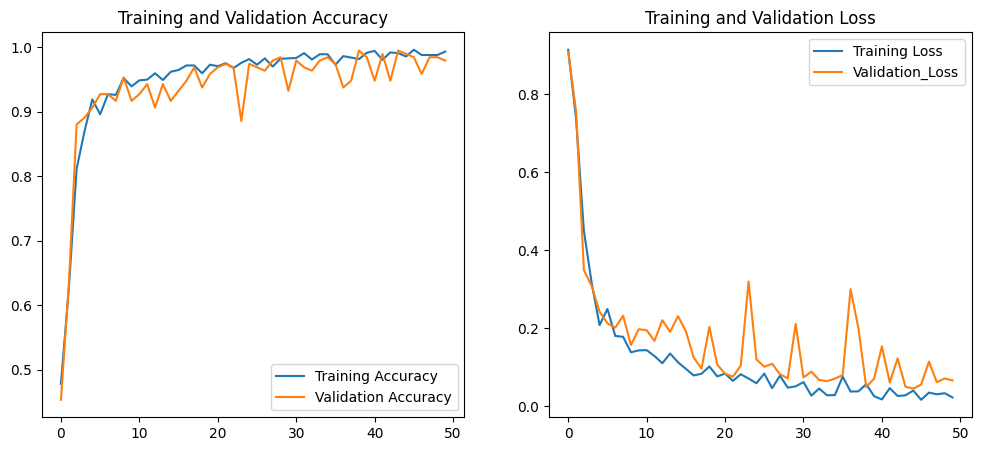

In [64]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label = 'Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label = 'Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')


plt.subplot(1,2,2)
plt.plot(range(EPOCHS),loss, label = 'Training Loss')
plt.plot(range(EPOCHS), val_loss, label = 'Validation_Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actural label:  Potato___Late_blight
1/1 [==============================] - 0s 144ms/step
[1.4859401e-03 9.9851400e-01 5.6006890e-15]
Predicted label:  Potato___Late_blight


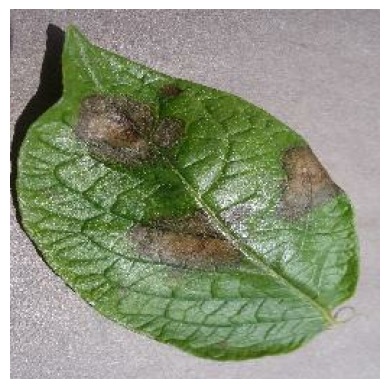

In [ ]:
for images_batch, labels_batch in test_ds.take(1):
  first_image = images_batch[0].numpy().astype('uint8')
  first_label = labels_batch[0].numpy()

  print('first image to predict')
  plt.imshow(first_image)
  print("actural label: ",class_names[first_label])
  plt.axis('off')

  batch_prediction =  model.predict(images_batch)
  print(batch_prediction[0])
  print("Predicted label: ",class_names[np.argmax(batch_prediction[0])])

In [65]:
def predict(model, img):
  img_array  = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
  img_array = tf.expand_dims(img_array,0) #Creating a batch

  predictions = model.predict(img_array)

  predicted_class = class_names[np.argmax(predictions[0])]
  confidence = round(100 * (np.max(predictions[0])),2)
  return predicted_class, confidence

1/1 [==============================] - 0s 46ms/step


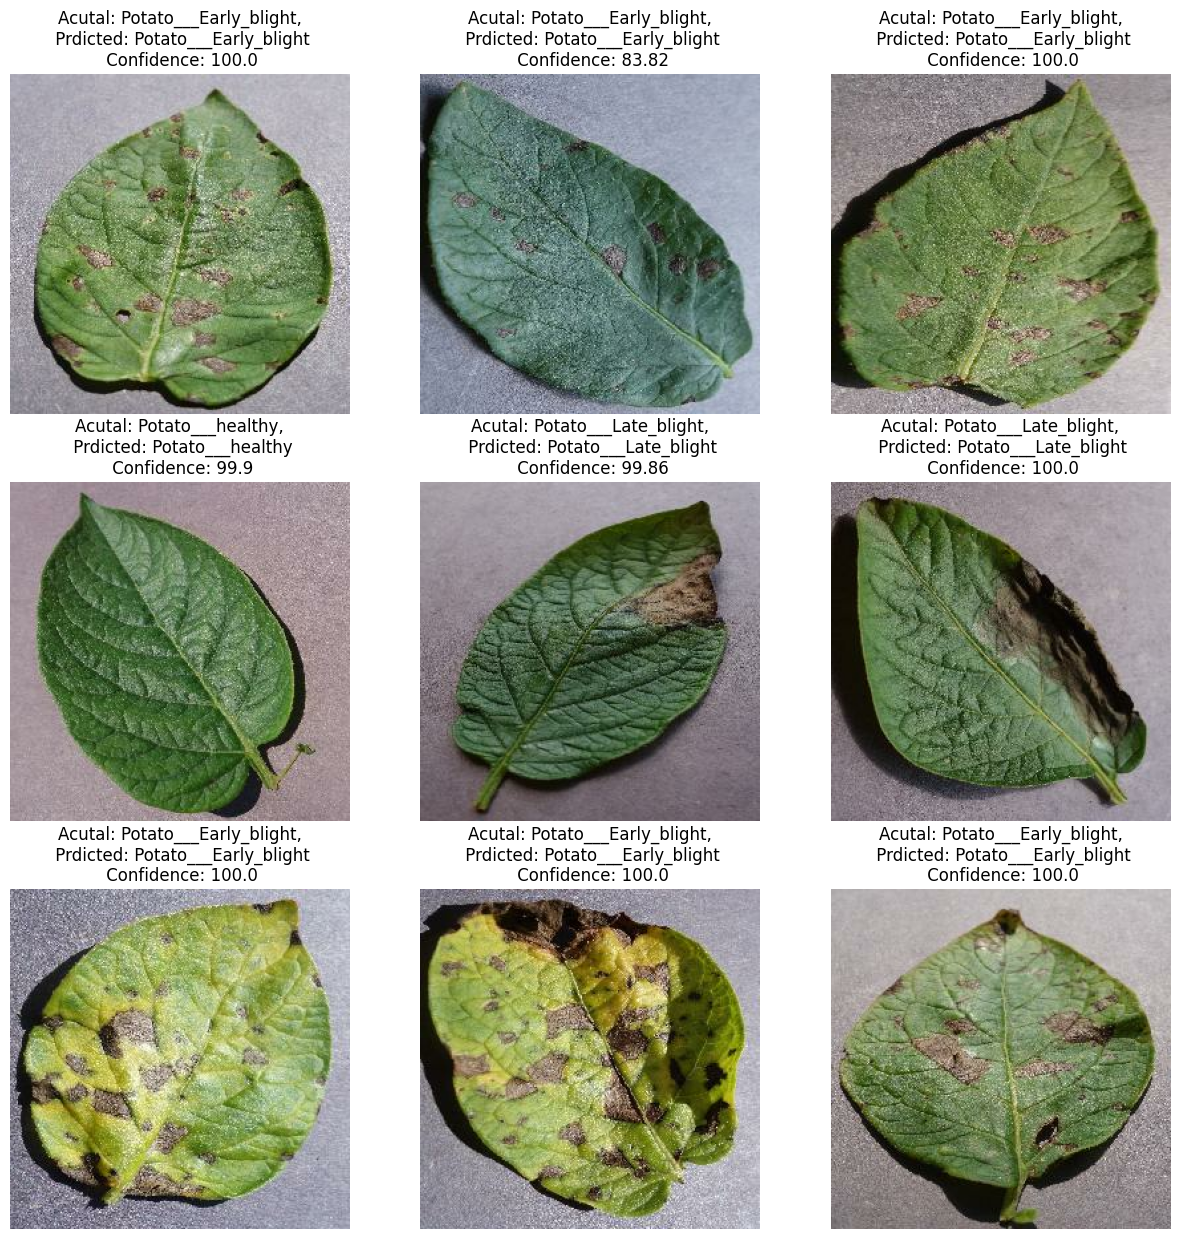

In [66]:
plt.figure(figsize = (15,15))
for images, labels in test_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3,3, i+1)
    plt.imshow(images[i].numpy().astype('uint8'))

    predicted_class, confidence = predict(model, images[i])

    actual_class = class_names[labels[i]]

    plt.title(f"Acutal: {actual_class},\n Prdicted: {predicted_class}\n Confidence: {confidence}")

    plt.axis("off")

In [67]:
#to generate next model version automatically
import os
model_version = max([int(i) for i in  os.listdir("Models")+ [0]])+1
model_version

1

In [68]:
model.save('Models/potatoTest2_acc_9835.h5')

c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [69]:
model_version = 2

model.save(f"Models/{model_version}")

INFO:tensorflow:Assets written to: Models/2\assets


INFO:tensorflow:Assets written to: Models/2\assets


In [70]:
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import load_model
model3 = load_model('Models/potatoTest2_acc_9835.h5')
batch = next(iter(test_ds))
images, labels = batch
Y_pred = model3.predict(images)
y_pred = np.argmax(Y_pred, axis = 1)
y_true = labels.numpy()
cm = confusion_matrix(y_true, y_pred)
print(cm)

1/1 [==============================] - 0s 251ms/step
[[5 0]
 [0 3]]


In [71]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         3

    accuracy                           1.00         8
   macro avg       1.00      1.00      1.00         8
weighted avg       1.00      1.00      1.00         8



In [72]:
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import load_model
model3 = load_model('Models/potatoTest2_acc_9835.h5')
all_y_pred = []
all_y_true = []

for batch in test_ds:
  images, labels = batch
  Y_pred = model3.predict(images)
  y_pred = np.argmax(Y_pred, axis = 1)
  y_true = labels.numpy()

  all_y_pred.extend(y_pred)
  all_y_true.extend(y_true)

cm = confusion_matrix(all_y_true, all_y_pred)
print(cm)

1/1 [==============================] - 0s 468ms/step
[[109   0   0]
 [  5  99   1]
 [  0   0  18]]


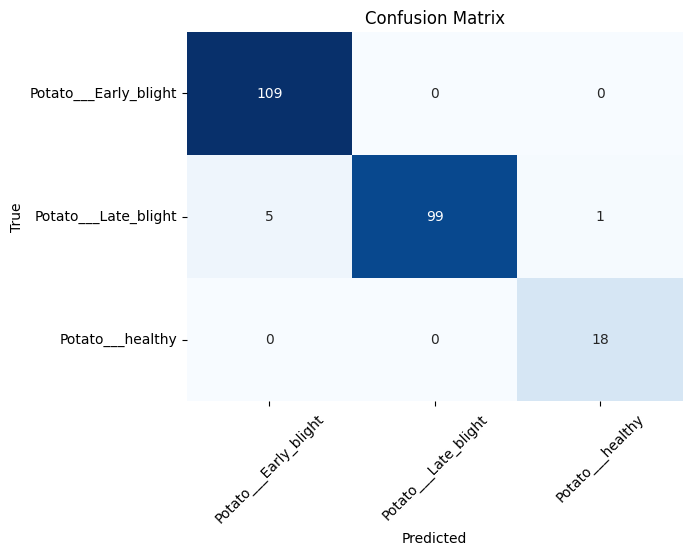

In [73]:
import seaborn as sns
fig, ax = plt.subplots()

# Plot the confusion matrix as a heatmap
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=class_names, yticklabels=class_names, ax=ax)

# Set axis labels and title
ax.set_xlabel("Predicted")
ax.set_ylabel("True")
ax.set_title("Confusion Matrix")

# Rotate tick labels if needed
plt.xticks(rotation=45)
plt.yticks(rotation=0)

# Show the plot
plt.show()

In [74]:
from sklearn.metrics import classification_report
print(classification_report(all_y_true, all_y_pred))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98       109
           1       1.00      0.94      0.97       105
           2       0.95      1.00      0.97        18

    accuracy                           0.97       232
   macro avg       0.97      0.98      0.97       232
weighted avg       0.98      0.97      0.97       232

